In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import datasets
import warnings
import os
import kaggle

pd.options.display.max_columns=100
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
%%time

if not os.path.exists('csv_files/wine_quality/'):
    os.makedirs('csv_files/wine_quality/')

for file in os.listdir('csv_files/wine_quality/'):
    file_path = os.path.join('csv_files/wine_quality/', file)
    if os.path.isfile(file_path):
        os.remove(file_path)

kaggle.api.dataset_download_files('camnugent/california-housing-prices', path='csv_files/wine_quality/', unzip=True)

CPU times: total: 141 ms
Wall time: 2.38 s


In [3]:
df=pd.read_csv('csv_files/wine_quality/housing.csv')

In [4]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


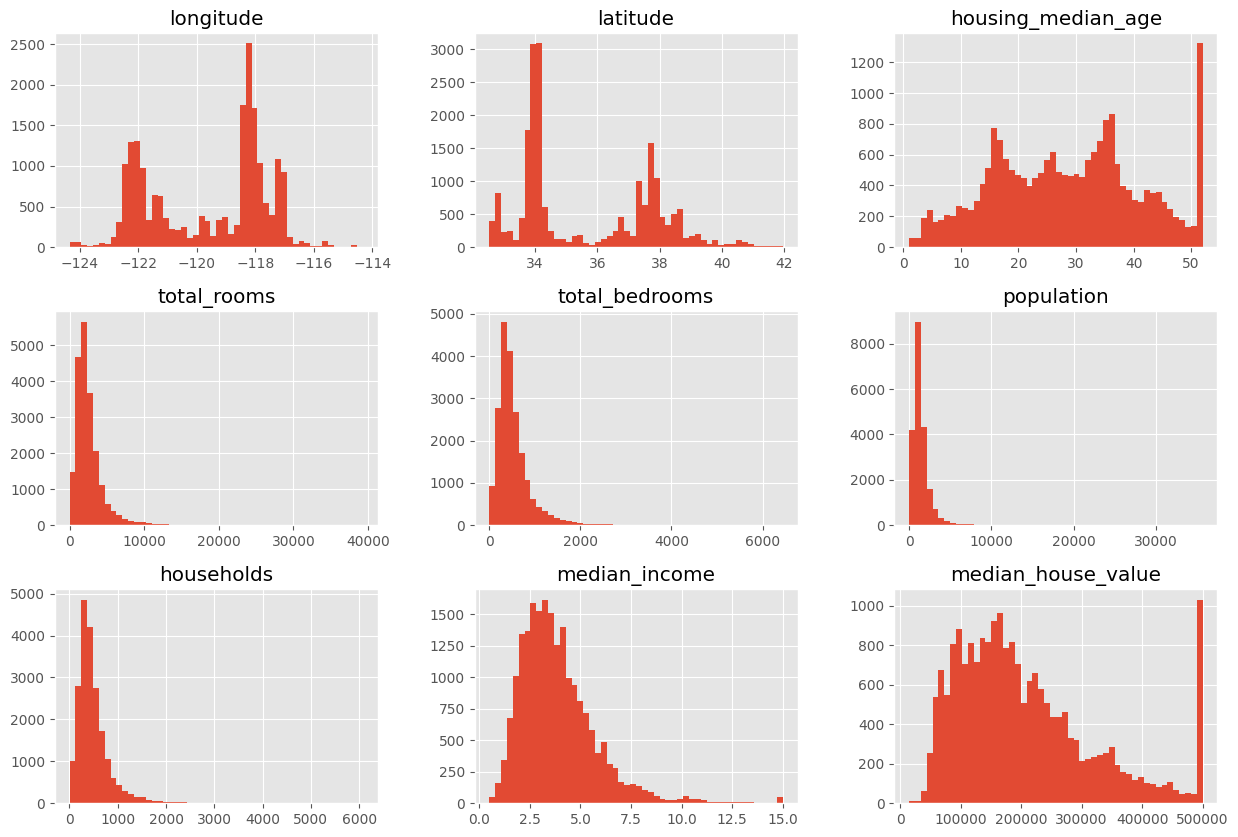

In [5]:
df.hist(figsize=(15,10),bins=50)
plt.show()

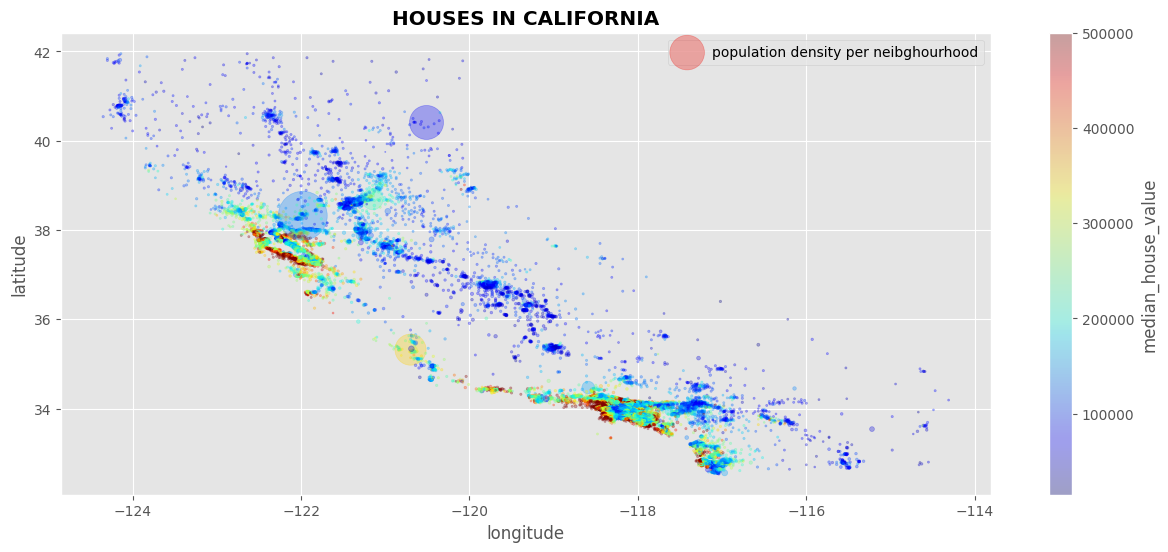

In [6]:
df.plot(figsize=(15,6),kind='scatter',x='longitude',y='latitude',alpha=0.3,
        s=df['population']/df['households'],c='median_house_value',cmap='jet',label='population density per neibghourhood')
plt.title('HOUSES IN CALIFORNIA',fontweight='bold')
plt.legend()
plt.show()

In [7]:
df=df[df['median_house_value']!=500001]
df=df[df['housing_median_age']!=52]

In [8]:
df['avg_rooms']=df['total_rooms']/df['households']
df['avg_bedrooms']=df['total_bedrooms']/df['total_rooms']
df['population_density']=df['population']/df['households']

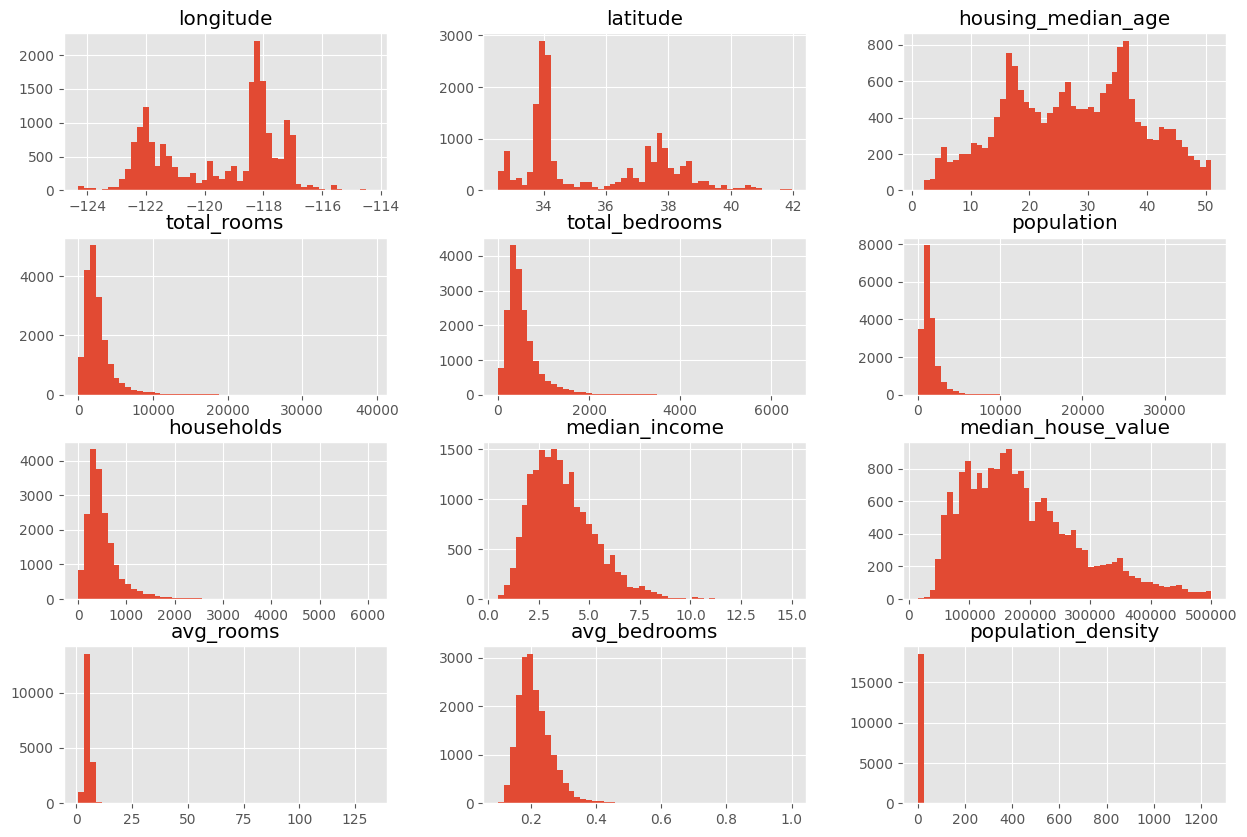

In [9]:
df.hist(figsize=(15,10),bins=50)
plt.show()

In [10]:
df.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.661039
total_rooms           0.152606
avg_rooms             0.113842
households            0.100220
total_bedrooms        0.079721
population            0.021616
housing_median_age    0.014772
population_density   -0.020347
longitude            -0.022165
latitude             -0.172126
avg_bedrooms         -0.229234
Name: median_house_value, dtype: float64

In [11]:
from sklearn.impute import SimpleImputer
imputer_mean=SimpleImputer(strategy='mean')
imputer_mode=SimpleImputer(strategy='most_frequent')

In [12]:
nan_columns=df.columns[df.isna().any()]
for nan_column in nan_columns:
    x=df[nan_column].isna().sum()
    y=round(df[nan_column].isna().sum()/len(df[nan_column]),2)
    if df[nan_column].dtypes=='object' and y<0.5:
        df[nan_column]=imputer_mode.fit_transform(df[[nan_column]])
    elif df[nan_column].dtypes in ['int','float'] and y<0.5:
        df[nan_column]=imputer_mean.fit_transform(df[[nan_column]])
    elif y>0.5:
        df.drop(nan_column,axis=1,inplace=True)

In [13]:
df[df.isna().any(axis=1)]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,avg_rooms,avg_bedrooms,population_density


In [14]:
object_columns=df.select_dtypes('object')
for object_column in object_columns:
    dummies=pd.get_dummies(df[object_column],prefix=object_column,dummy_na=False)
    df=df.drop(object_column,axis=1)
    df=pd.concat([df,dummies],axis=1)

In [15]:
df.columns=df.columns.str.replace('>','').str.replace('<','')

In [16]:
X=df.drop('median_house_value',axis=1)
Y=df['median_house_value']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=12)

In [17]:
from xgboost import XGBRegressor
model=XGBRegressor()

[learning_curve] Training set sizes: [ 990 1980 2971 3961 4952 5942 6932 7923 8913 9904]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished


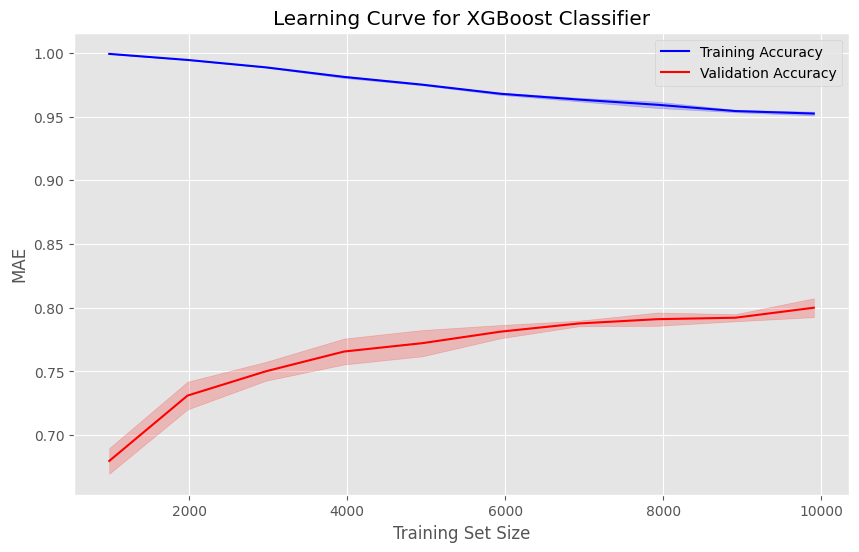

In [18]:
from sklearn.model_selection import learning_curve

train_sizes,train_scores,test_scores=learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1,1,10),
    cv=3,
    scoring='r2',
    verbose=1)

train_scores_mean=np.mean(train_scores,axis=1)
train_scores_std=np.std(train_scores,axis=1)
test_scores_mean=np.mean(test_scores,axis=1)
test_scores_std=np.std(test_scores,axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy', color='red')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('MAE')
plt.title('Learning Curve for XGBoost Classifier')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid={'n_estimators':[200,500,1000],
            'learning_rate':[0.01,0.1,0.2],
            'max_depth':[2,4,7]}

grid_search_cv=GridSearchCV(estimator=model,param_grid=param_grid,cv=3,scoring='neg_mean_absolute_error',verbose=10)
grid_search_cv.fit(X_train,y_train)

best_model=grid_search_cv.best_estimator_
print(grid_search_cv.best_estimator_)
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START learning_rate=0.01, max_depth=2, n_estimators=200..........
[CV 1/3; 1/27] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=-46872.958 total time=   1.7s
[CV 2/3; 1/27] START learning_rate=0.01, max_depth=2, n_estimators=200..........
[CV 2/3; 1/27] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=-46446.049 total time=   1.8s
[CV 3/3; 1/27] START learning_rate=0.01, max_depth=2, n_estimators=200..........
[CV 3/3; 1/27] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=-47593.737 total time=   1.3s
[CV 1/3; 2/27] START learning_rate=0.01, max_depth=2, n_estimators=500..........
[CV 1/3; 2/27] END learning_rate=0.01, max_depth=2, n_estimators=500;, score=-40497.387 total time=   3.5s
[CV 2/3; 2/27] START learning_rate=0.01, max_depth=2, n_estimators=500..........
[CV 2/3; 2/27] END learning_rate=0.01, max_depth=2, n_estimators=500;, score=-39550.369 total time=   3.7s

[CV 2/3; 15/27] END learning_rate=0.1, max_depth=4, n_estimators=1000;, score=-27595.638 total time=  10.7s
[CV 3/3; 15/27] START learning_rate=0.1, max_depth=4, n_estimators=1000.........
[CV 3/3; 15/27] END learning_rate=0.1, max_depth=4, n_estimators=1000;, score=-27948.611 total time=  10.7s
[CV 1/3; 16/27] START learning_rate=0.1, max_depth=7, n_estimators=200..........
[CV 1/3; 16/27] END learning_rate=0.1, max_depth=7, n_estimators=200;, score=-28092.332 total time=   3.6s
[CV 2/3; 16/27] START learning_rate=0.1, max_depth=7, n_estimators=200..........
[CV 2/3; 16/27] END learning_rate=0.1, max_depth=7, n_estimators=200;, score=-27585.829 total time=   3.7s
[CV 3/3; 16/27] START learning_rate=0.1, max_depth=7, n_estimators=200..........
[CV 3/3; 16/27] END learning_rate=0.1, max_depth=7, n_estimators=200;, score=-27788.181 total time=   3.5s
[CV 1/3; 17/27] START learning_rate=0.1, max_depth=7, n_estimators=500..........
[CV 1/3; 17/27] END learning_rate=0.1, max_depth=7, n_esti

[0]	validation_0-mae:170736.04184	validation_1-mae:170971.74128
[1]	validation_0-mae:153806.36845	validation_1-mae:154000.08345
[2]	validation_0-mae:138563.34073	validation_1-mae:138705.52000
[3]	validation_0-mae:124846.62615	validation_1-mae:125010.35819
[4]	validation_0-mae:112500.21991	validation_1-mae:112696.30742
[5]	validation_0-mae:101418.46423	validation_1-mae:101671.31306
[6]	validation_0-mae:91481.10075	validation_1-mae:91807.00724
[7]	validation_0-mae:82579.36392	validation_1-mae:83020.28263
[8]	validation_0-mae:74674.51168	validation_1-mae:75255.22330
[9]	validation_0-mae:67660.41833	validation_1-mae:68524.90603
[10]	validation_0-mae:61506.41782	validation_1-mae:62650.97285
[11]	validation_0-mae:56134.52291	validation_1-mae:57630.99118
[12]	validation_0-mae:51478.61575	validation_1-mae:53326.22464
[13]	validation_0-mae:47489.63462	validation_1-mae:49653.55212
[14]	validation_0-mae:44044.25464	validation_1-mae:46626.44491
[15]	validation_0-mae:41076.64889	validation_1-mae:44

[130]	validation_0-mae:16397.37073	validation_1-mae:28623.62923
[131]	validation_0-mae:16351.81052	validation_1-mae:28626.89769
[132]	validation_0-mae:16309.91765	validation_1-mae:28626.67082
[133]	validation_0-mae:16255.06951	validation_1-mae:28599.95860
[134]	validation_0-mae:16154.35027	validation_1-mae:28539.81255
[135]	validation_0-mae:16108.33390	validation_1-mae:28539.42329
[136]	validation_0-mae:16087.80443	validation_1-mae:28536.93394
[137]	validation_0-mae:16072.10969	validation_1-mae:28545.86670
[138]	validation_0-mae:16028.51866	validation_1-mae:28537.93082
[139]	validation_0-mae:15974.53961	validation_1-mae:28537.65169
[140]	validation_0-mae:15900.23556	validation_1-mae:28514.57015
[141]	validation_0-mae:15841.58754	validation_1-mae:28504.64016
[142]	validation_0-mae:15827.06606	validation_1-mae:28505.70220
[143]	validation_0-mae:15745.14740	validation_1-mae:28482.11990
[144]	validation_0-mae:15672.23513	validation_1-mae:28465.49696
[145]	validation_0-mae:15605.02382	valid

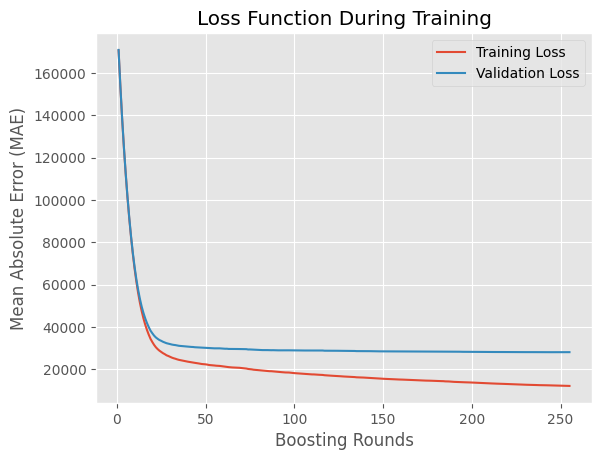

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)


# Fit the model and monitor the loss function on the training and validation sets
eval_set = [(X_train, y_train), (X_valid, y_valid)]
best_model.fit(X_train, y_train, eval_set=eval_set, eval_metric='mae', early_stopping_rounds=10, verbose=1)

# Access the training history
results = best_model.evals_result()
train_loss = results['validation_0']['mae']
val_loss = results['validation_1']['mae']
epochs = range(1, len(train_loss) + 1)

# Plot the loss function during training
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Loss Function During Training')
plt.legend()
plt.show()

In [21]:
test_prediction=best_model.predict(X_test)
from sklearn import metrics


r2_test=metrics.r2_score(test_prediction,y_test)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)

print(r2_test,mae_test,rmse_test)

0.7742519373040935 27393.84433041723 40967.46632209145


In [22]:
train_prediction=best_model.predict(X_train)

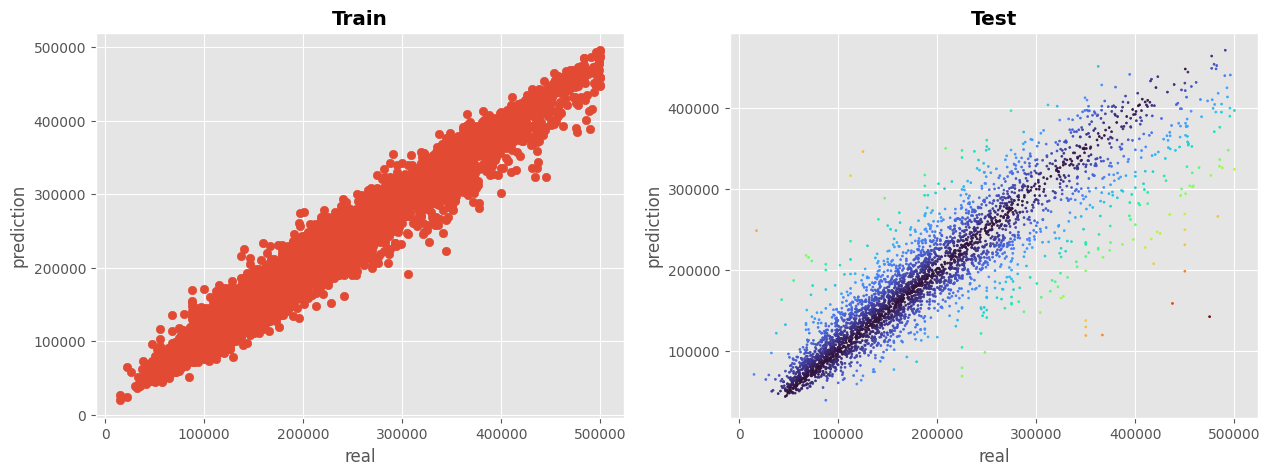

In [23]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('Train',fontweight='bold')
ax2.scatter(y_test,test_prediction,c=(y_test-test_prediction).abs(),cmap='turbo',s=2)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('Test',fontweight='bold')
plt.show()

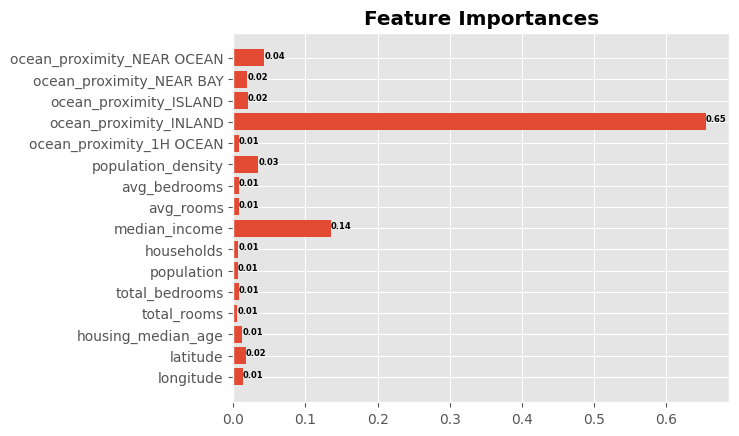

In [24]:
feature_weights=best_model.feature_importances_
feature_names=best_model.feature_names_in_

plt.barh(feature_names,feature_weights)
plt.title('Feature Importances',fontweight='bold')
for i in range(len(feature_names)):
    plt.text(feature_weights[i],i,feature_weights[i].round(2),fontweight='bold',size=6)
plt.show()